In [45]:
import torch
from torch import nn
import torch.optim as optim
import pygame
import json 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd

In [63]:
# SCREEN_WIDTH    = 100
# SCREEN_HEIGHT   = 20
# FONT_SIZE       = 10 

SEED = 0    # TODO: define seed of python, numpy, torch

SCREEN_WIDTH    = 130
SCREEN_HEIGHT   = 25
FONT_SIZE       = 15 
# 4680
FONT_PATH           = "../converttext/noto-sans.regular.ttf"
PATH_WORD_NUM_DICT  = 'word_num_dict.json'
PATH_WORD_TO_ID     = 'word_to_id_dict.json'
PATH_ID_TO_WORD     = 'id_to_word_dict.json'

DEVICE_NAME         = "cuda:0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MODEL_OUT_CHANNELS  = 16
MODEL_KERNEL_SIZE   = 3
MODEL_SITRIDE       = 1
MODEL_PADDING       = 1
MODEL_LINEAR_SIZE   = 12480
OPTIM_LEARNING_RATE = 0.001

TRAIN_BATCH_SIZE    = 16
DEV_BATCH_SIZE      = 16
TRAIN_NUM_EPOCHS    = 10

PATH_FOLDER_NAME = f"CNN_"
# os.mkdir(PATH_FOLDER_NAME)      # TODO: if already exist or time

PATH_CONFIG = "./{PATH_FOLDER_NAME}/config.json"    # TODO: save config in json
PATH_TRAIN_LOSS_PLOT = f"./{PATH_FOLDER_NAME}/train_loss.jpg"
PATH_DEV_ACC_PLOT    = f"./{PATH_FOLDER_NAME}/dev_loss.jpg"
PATH_DEV_CONF_PLOT   = f"./{PATH_FOLDER_NAME}/dev_loss.jpg"

PATH_DATA   = f"./{PATH_FOLDER_NAME}/train_data.csv"    # 
PATH_EVALUATE_DATA_PREFIX   = f"./{PATH_FOLDER_NAME}/eval_data"    # 
PATH_MODEL  = f"./{PATH_FOLDER_NAME}/CNN.pth"

In [32]:
class CNN(nn.Module):
    def __init__(self, out_channels=6, kernel_size=1, stride=1, padding=0, vocab_size=5000, linear_size=5000, normalization=False):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=out_channels, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(linear_size, vocab_size) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [33]:
pygame.init()
font_noto_sans_regular = pygame.font.Font(FONT_PATH, FONT_SIZE)


def to_image(text:str, font, id:int=None, noise=False):
  # pygame.init()
  # screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
  screen = pygame.Surface((SCREEN_WIDTH, SCREEN_HEIGHT))
  screen.fill((255, 255, 255))
  # draw image
  img = font.render(str(text), True, (0, 0, 0))
  screen.blit(img, (2, 0))
  for event in pygame.event.get():
    if event.type == pygame.QUIT:
      run = False
  # pygame.display.flip() 
  # Save the screen as an image when the program finishes
  if noise == False:
    # TODO: obtain font name
    filename = f"./temp_image/word_{str(id)}_{str(text)}_notoSans.png"
  else:
    filename = f"./temp_image/word_{str(id)}_{str(text)}_notoSans_noised.png"
  pygame.image.save(screen, filename)
  # print("Screen saved as ", filename)
  # pygame.quit()
  return filename

image_path = to_image(text="1nd1st1nguishαble", font=font_noto_sans_regular, id=5, noise=False)


In [34]:
# load dictionary

with open(PATH_WORD_NUM_DICT, 'r') as fp:
    word_num_dict_test = json.load(fp)
with open(PATH_WORD_TO_ID, 'r') as fp:
    word_to_id_dict_test = json.load(fp)
with open(PATH_ID_TO_WORD, 'r') as fp:
    id_to_word_dict_test = json.load(fp)
    
print("test load: length of word_num_dict:", len(word_num_dict_test.keys()))
print("test load: length of word_to_id_dict_test:", len(word_to_id_dict_test.keys()))
print("test load: length of id_to_word_dict_test:", len(id_to_word_dict_test.keys()))
print('note index needs to use str(index)')
print(f"test load: index: [5], word in id_to_word_dict: [{id_to_word_dict_test[str(5)]}], id in word_id_dict: [{word_to_id_dict_test[id_to_word_dict_test['5']]}]")

VOCAB_SIZE = len(word_num_dict_test.keys())


test load: length of word_num_dict: 4572
test load: length of word_to_id_dict_test: 4572
test load: length of id_to_word_dict_test: 4572
note index needs to use str(index)
test load: index: [5], word in id_to_word_dict: [defines], id in word_id_dict: [5]


In [35]:
# define dataset

transform_norm = transforms.Compose([
    transforms.ToTensor(),
])
class WordImageIDDataset(Dataset):
    def __init__(self, word_to_id_list, font, noise=False):
        self.word_to_id_list = word_to_id_list
        self.font = font
        self.noise = noise
    
    def __len__(self):
        return len(self.word_to_id_list)
    
    def __getitem__(self, index):
        ''' index is not token ID '''
        output_word = self.word_to_id_list[index][0]
        image_path = to_image(
            text=output_word, 
            font=self.font,
            id=index, 
            noise=self.noise)
        
        # for path in image_paths:
        output_img = Image.open(image_path).convert('L')
        output_img = transform_norm(output_img)
        id = self.word_to_id_list[index][1]
        # output_id_onehot = torch.zeros(1, VOCAB_SIZE)
        # output_id_onehot[0][id] = 1
        output_id_onehot = torch.zeros(VOCAB_SIZE)
        output_id_onehot[id] = 1
                
        output = {'word'    : output_word,
                  'image'   : output_img,
                  'id'      : output_id_onehot}
        return output

In [36]:
model = CNN(out_channels=MODEL_OUT_CHANNELS, 
            kernel_size=MODEL_KERNEL_SIZE, 
            stride=MODEL_SITRIDE, 
            padding=MODEL_PADDING, vocab_size=VOCAB_SIZE, normalization=False, linear_size=MODEL_LINEAR_SIZE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=OPTIM_LEARNING_RATE)
dataset = WordImageIDDataset(word_to_id_list = list(word_to_id_dict_test.items()),
                            font=font_noto_sans_regular,
                            noise=False)
train_dataloader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

epoch: 1


10.404739003081422
epoch: 2
7.952828575681139
epoch: 3
6.914903910843642
epoch: 4
4.160732591068828
epoch: 5
1.436811769446293
epoch: 6
0.5370438556883719
epoch: 7
0.2647618934271167
epoch: 8
0.15652822650369855
epoch: 9
0.09911838704329375
epoch: 10
0.07012109802156635


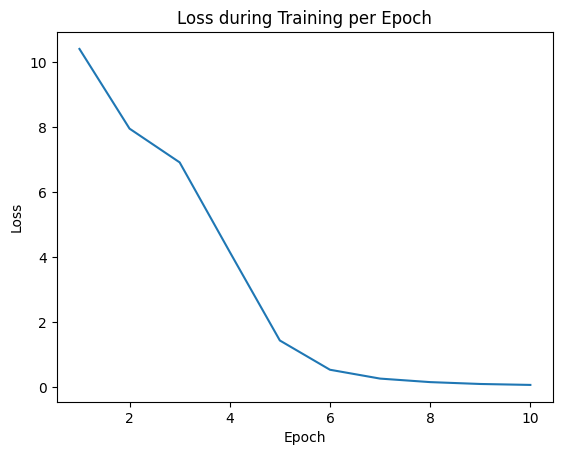

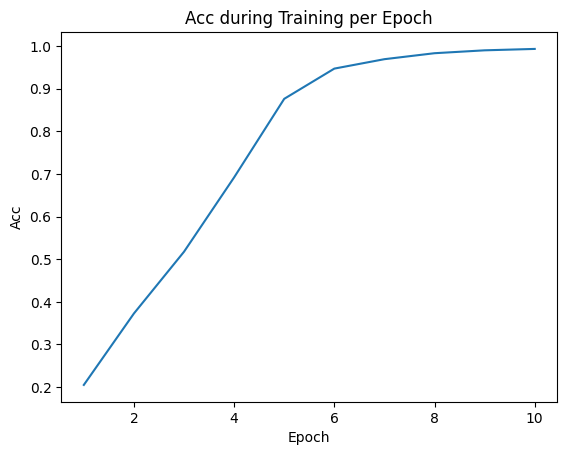

In [37]:
train_loss = []
epoch_acc = []
for epoch in range(1, TRAIN_NUM_EPOCHS + 1):
    print(f'epoch: {epoch}')
    model.train()
    epoch_loss = []

    for data in train_dataloader:
        words    = data['word']
        imgs     = data['image']
        ids      = data['id']
        optimizer.zero_grad()
        # print(word)
        # print(imgs.shape)
        # print(id)
        # print(ids.shape)
        # read image    
        outputs = model(imgs.to(device))
        # print(output)
        # softmax = torch.nn.Softmax()
        # outputs = softmax(outputs)
        # print(pred) 
        # print(preds.shape)
        # print(ids.shape)
        
        loss = criterion(outputs, ids.to(device))
        # print("Loss:", loss.item())
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        # torch.cuda.empty_cache()
    epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    print(epoch_average_loss)
    train_loss.append(epoch_average_loss)

    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in eval_dataloader:
            words    = data['word']
            imgs     = data['image']
            ids      = data['id']
            outputs = model(imgs.to(device))
            _, targets = torch.max(ids.data, 1)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets.to(device)).sum().item()
    epoch_acc.append(correct/total)
    print(f"acc: {epoch_acc[-1]}")
x = range(1, TRAIN_NUM_EPOCHS+1)
plt.plot(x, train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training per Epoch')
plt.savefig(PATH_TRAIN_LOSS_PLOT)
plt.show()

plt.plot(x, epoch_acc)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc during Training per Epoch')
plt.savefig(PATH_DEV_ACC_PLOT)
plt.show()

# TODO: save data as csv
# TODO: validation (dev)


In [48]:
# save the loss and acc during training
data = pd.DataFrame({'train_loss':train_loss,
                     'train_acc':epoch_acc})

data.to_csv(PATH_DATA)


In [39]:
torch.save(model, PATH_MODEL)

#### Evaluate the final accuracy 

In [ ]:
# model = torch.load(PATH_MODEL)

In [59]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    all_word_list       = []
    all_id_list         = []
    all_pred_id_list       = []
    all_compare_list    = []
    
    for data in eval_dataloader:
        # data = next(iter(eval_dataloader))
        # data = next(iter(eval_dataloader))
        words    = data['word']     # list
        imgs     = data['image']
        ids      = data['id']
        
        outputs = model(imgs.to(device))
        _, targets = torch.max(ids.data, 1)         # torch.Size([16])
        _, predicted = torch.max(outputs.data, 1)   # torch.Size([16])
        # print("words: ", len(words))
        # print("ids: ", ids.shape)
        # print("targets: ", targets.shape)
        # print("targets: ", targets.tolist())
        # print("outputs: ", outputs.shape)
        # print("predicted: ", predicted.shape)
        total += targets.size(0)
        compare = predicted == targets.to(device)
        # print("compare: ", compare.shape)
        correct += compare.sum().item()             # torch.Size([16])
        
        all_word_list.extend(words)
        all_id_list.extend(targets.tolist())
        all_pred_id_list.extend(predicted.tolist())
        all_compare_list.extend(compare.tolist())
        # print("targets: ", targets)
        # print("predicted: ", predicted)
        # print("correct: ", correct)
        # break
    evaluate_acc = correct/total
    print(evaluate_acc)

0.9930008748906387


In [60]:
print(all_word_list   )
print(all_id_list     )
print(all_pred_id_list   )
print(all_compare_list)
all_pred_word_list = [id_to_word_dict_test[str(pred_id)] for pred_id in all_pred_id_list]
print(all_pred_word_list)

evaluate_data = pd.DataFrame({'word':all_word_list,
                     'real_id':all_id_list,
                     'pred_word':all_pred_word_list,
                     'pred_id':all_pred_id_list,
                     'eval':all_compare_list,
                     })

evaluate_data.to_csv(PATH_EVALUATE_DATA_PREFIX+f"_{round(evaluate_acc*100, 2)}.csv")


['Times', 'requires', 'Streets', 'larger', 'economically', 'billion', 'groups', 'relatively', 'go', 'documentary', 'unsurprisingly', 'vastness', 'letter', 'verbally', 'pools', 'indistinguishable', 'choosing', 'bills', 'neighborhood', 'mild', 'element', 'carpeting', 'veteran', 'She', 'not', 'refrigerators', 'ends', 'campaigning', 'some', 'sensation', 'approaches', 'Which', 'explained', 'attended', 'faster', 'meets', 'Food', 'sits', 'exam', 'peacefully', 'illustrated', 'had', 'scientists', 'crowd', 'Ansel', 'infected', 'syringe', 'distracted', 'portion', 'Jahnani', 'convince', 'ground', 'bargaining', 'comparable', 'investment', 'result', 'stewardship', 'robotic', 'Rizzolatti', 'cement', 'lamps', 'eater', 'mines', 'affliction', 'wellness', 'Plain', 'wrapped', 'Is', 'braking', 'steps', 'Obaid', 'pronounce', 'shifts', 'impossible', 'Four', 'algebra', 'executive', 'wounds', 'truck', 'Haïba', 'occupation', 'warm', 'Institute', 'photosynthetic', 'tenth', 'holiest', 'next', 'Poet', 'receptive',